# Build Quality Metrics on Perturbed Input

Now that we have a method of perturbing text input based on word vectors, we can build it into the metrics for assessing explanation quality, such as local Lipschitz, which requires two primary components within the optimization problem:
* The distance between explanations for original and perturbed inputs
* The distance between the actual inputs
  * This is what's bounded by the radius
  
The former is pretty straightforward to obtain - the latter is somewhat less intuitive for comparison across models. Having a common perturbation across models gets us partially there, but I think we still want a quantitative measure of measuring the distance between inputs. We have a couple of options now:
* Inverse cosine similarity, using TF-IDF vectorizer on the original and perturbed text
* L2 distance between the original and perturbed embedding matrices (using word2vec for the BOW model and the transformer's own embedding matrix)


Here's the formula for local Lipschitz:

$$\hat{L}(x_i) = \underset{x_j \in B_\epsilon(x_i)}{\operatorname{argmax}} \frac{||f(x_i) - f(x_j)||_2}{||x_i - x_j||_2}$$

Notes on this formula:
* $f(x)$ is the explanation function
* $x_i$ is the original point, and $x_j$ is the perturbed point
* $B_\epsilon(x_i)$ is the L-infinity ball ("neighborhood") around $x_i$, with radius $\epsilon$
  * In other words, we don't consider points where $||x_i - x_j||_2 > \epsilon$
* We still have to figure out how to do the maximization, but I guess we could sample and take the maximizing distance
  * $x_j$ is the object of the argmax (since it appears below the operator along with its constraints), but the return value should be the distance between $x_i$ and $x_j$
    * In section 3.2, the authors say the following (with (1) being the Lipschitz formula above):
    > It is illustrative to compare the explanations provided by each method for the model's prediction for some point $x_i$ and its adversarially chosen worst-case deviation, i.e., the $x_j$ maximizing (1) for that $x_i$
  * The authors of this paper (*On the Robustness of Interpretability Methods*) use `skopt` for the maximization function
  
  
There is also a separate formula provided in that paper, which gives an empirical approach for cases where continuous perturbation is not meaningful, and works with a given fixed test set. This formula computes pairwise distance between points in the test set, and allows the sampling to use neighboring points within a specific radius rather than relying on perturbation. This may well work for us, in that we can calculate neighborhoods using cosine similarity of Tf-Idf document vectors, and then just evaluate the difference in explanations. We could perhaps consider aggregating to the token level for more apples-to-apples comparison of explanation distance

In [1]:
import input_perturbation as ip
from gensim.models import KeyedVectors
import os
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from interpret.glassbox import ExplainableBoostingClassifier, LogisticRegression
from interpret.blackbox import ShapKernel, LimeTabular
import pandas as pd
import numpy as np
import swifter
import nltk
import re
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook

plt.style.use('seaborn-whitegrid')

/opt/conda/envs/imlh/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Load everything we need - we store data in cloud storage, but the following directory can be wherever the data preparation command in the `clinical-outcome-prediction` repo saved the final CSV files.

In [ ]:
TRANSFORMER_NAME = 'XXXX/bigbird-base-mimic-mortality' # HuggingFace username redacted 
DATA_DIR = 'gs://hds-modeling-files/2021Q2-IMLH/mortality-prediction'
MODEL_DIR = os.path.join('..', 'models')

In [3]:
bigbird = AutoModelForSequenceClassification.from_pretrained(TRANSFORMER_NAME)
bb_tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_NAME)

In [4]:
lr_vectorizer = pickle.load(open(os.path.join('..', 'models', 'best_lr_vectorizer.p'), 'rb'))
lr = pickle.load(open(os.path.join('..', 'models', 'best_lr_model.p'), 'rb'))

ebm_vectorizer = pickle.load(open(os.path.join('..', 'models', 'best_ebm_vectorizer.p'), 'rb'))
ebm = pickle.load(open(os.path.join('..', 'models', 'best_ebm_model.p'), 'rb'))

rf_vectorizer = pickle.load(open(os.path.join('..', 'models', 'best_rf_vectorizer.p'), 'rb'))
rf = pickle.load(open(os.path.join('..', 'models', 'best_rf_model.p'), 'rb'))

In [5]:
mp_valid = pd.read_csv(os.path.join(DATA_DIR, "MP_IN_adm_val.csv"))

Normalize the text in the validation set.

In [6]:
stop_words = set(nltk.corpus.stopwords.words('english'))
stemmer = nltk.stem.porter.PorterStemmer()
def text_norm(text:str):
    # scrub de-id artifacts
    text = re.sub(r'\[\*\*.{,40}?\*\*\]', '', text)
    
    for sw in stop_words:
        text = re.sub(r'\b{}\b'.format(sw), ' ', text)
        
    # replace numbers with [NUM]
    text = re.sub(r'\d+', ' numbertoken ', text)
    
    text = re.sub(r'\s+', ' ', text)
    # the .strip() at the end makes sure we don't have any leading/trailing spaces
    no_stops_text = ' '.join(filter(lambda w: (len(w) > 1 and w not in stop_words) or w == '~', 
                           re.split(r'\s+', text))).strip()

    # stemming
    normed = ' '.join(map(stemmer.stem, re.split(r'\s+', no_stops_text)))
    
    return normed

In [7]:
mp_valid['text_norm'] = mp_valid['text'].swifter.apply(text_norm)

Pandas Apply:   0%|          | 0/4918 [00:00<?, ?it/s]

## Pairwise Distance
Since there is another formula that works for a finite test set instead of continuous perturbations, we can explore the pairwise distances between vectorized documents in our validation set. We'll use the TF-IDF vectorizer we used for our best logistic regression model.

In [8]:
valid_tfidf = lr_vectorizer.transform(mp_valid['text_norm'])

In [9]:
valid_distances = euclidean_distances(valid_tfidf)
valid_cosine_dist = cosine_distances(valid_tfidf)

In [10]:
all_valid_distances = np.tril(valid_distances).flatten()
all_valid_distances = all_valid_distances[all_valid_distances != 0]

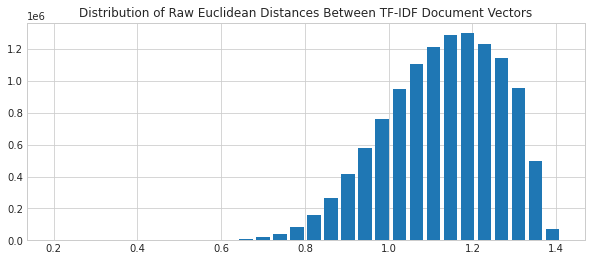

In [11]:
plt.figure(figsize=(10, 4))
plt.hist(all_valid_distances, rwidth=0.8, bins=30)
plt.title("Distribution of Raw Euclidean Distances Between TF-IDF Document Vectors")
plt.show()

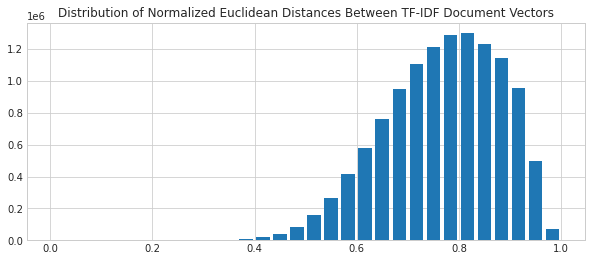

In [12]:
plt.figure(figsize=(10, 4))
plt.hist((all_valid_distances - all_valid_distances.min()) / (all_valid_distances.max() - all_valid_distances.min()), 
         rwidth=0.8, bins=30)
plt.title("Distribution of Normalized Euclidean Distances Between TF-IDF Document Vectors")
plt.show()

Now let's look at each observation's distance to its closest neighbor by taking the row-wise minimum (excluding the diagonal entry, which is the distance between the point and itself, i.e. 0)

In [13]:
rowwise_minima = []

for i in range(valid_distances.shape[0]):
    off_diagonal = np.concatenate([
        valid_distances[i, :i],
        valid_distances[i, (i+1):]
    ])
    
    rowwise_minima.append(off_diagonal.min())

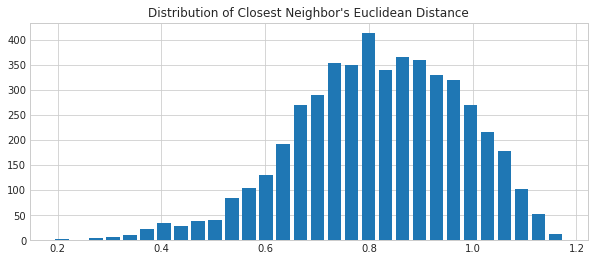

In [14]:
plt.figure(figsize=(10, 4))
plt.hist(rowwise_minima, rwidth=0.8, bins=30)
plt.title("Distribution of Closest Neighbor's Euclidean Distance")
plt.show()

Let's do the same thing, but with cosine distances

In [15]:
all_cosine_distances = np.tril(valid_cosine_dist).flatten()
all_cosine_distances = all_cosine_distances[all_cosine_distances != 0]

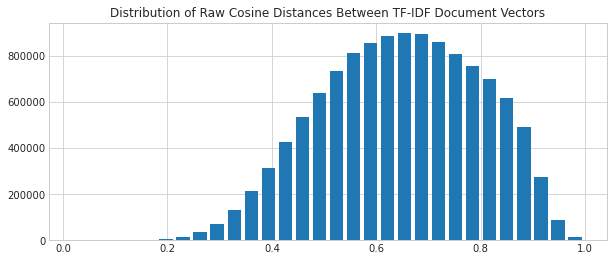

In [16]:
plt.figure(figsize=(10, 4))
plt.hist(all_cosine_distances, rwidth=0.8, bins=30)
plt.title("Distribution of Raw Cosine Distances Between TF-IDF Document Vectors")
plt.show()

Already normalized, so that's good. Seems a better distribution as well. Let's check the rowwise minima here too

In [17]:
rowwise_minima_cosine = []

for i in range(valid_cosine_dist.shape[0]):
    off_diagonal = np.concatenate([
        valid_cosine_dist[i, :i],
        valid_cosine_dist[i, (i+1):]
    ])
    
    rowwise_minima_cosine.append(off_diagonal.min())

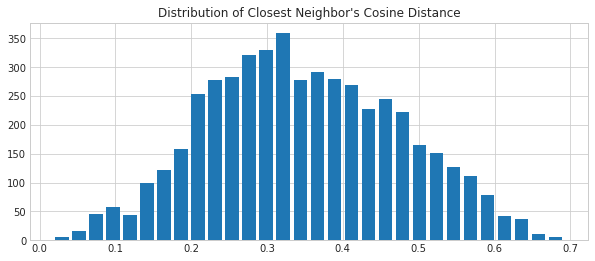

In [18]:
plt.figure(figsize=(10, 4))
plt.hist(rowwise_minima_cosine, rwidth=0.8, bins=30)
plt.title("Distribution of Closest Neighbor's Cosine Distance")
plt.show()

Sheesh, so for every point to have at least one neighbor, we need to allow a cosine distance of near 0.7. This is for the full validation set as well!

## Perturbation-Based Distances

Since we're rolling with vectorizer-based distances, let's keep the momentum going and examine how these measures react when using the word vector perturbation method. Hopefully, we'll be able to have closer neighborhoods than with the pairwise distance above.

In [19]:
wv = KeyedVectors.load(os.path.join(MODEL_DIR, 'trained_word2vec.wordvectors'))

In [20]:
wv.most_similar('coumadin')

[('warfarin', 0.7606382369995117),
 ('anticoagul', 0.6506252288818359),
 ('pradaxa', 0.6005820631980896),
 ('anticoagulation', 0.586206316947937),
 ('lovenox', 0.5739354491233826),
 ('dabigatran', 0.5287347435951233),
 ('sotalol', 0.5181922912597656),
 ('flutt', 0.489547461271286),
 ('plavix', 0.4874141812324524),
 ('digoxin', 0.4813327193260193)]

In [21]:
perturb_sample = mp_valid.sample(50, random_state=555)

In [22]:
def distance_between_text_pair(original, perturbed, vectorizer, distance_fn='cosine'):
    tfidf = vectorizer.transform([original, perturbed])
    if distance_fn == 'cosine':
        distance = cosine_distances(tfidf)
    elif distance_fn == 'euclidean':
        distance = euclidean_distances(tfidf)
    return distance[0, 1]

In [23]:
distance_between_text_pair(perturb_sample['text_norm'].iloc[0],
                           ip.perturb_input_text_gensim(perturb_sample['text_norm'].iloc[0], wv=wv), 
                           lr_vectorizer)

0.05684605136664089

Document:   0%|          | 0/50 [00:00<?, ?it/s]

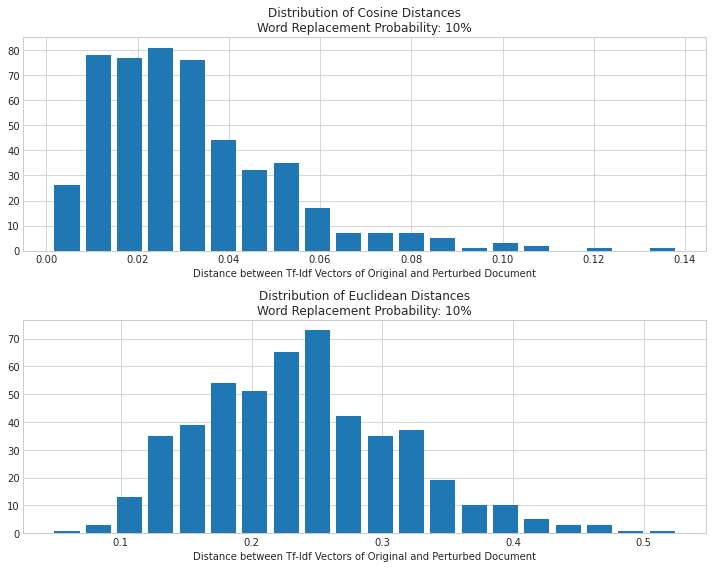

In [24]:
N_DOCS = perturb_sample.shape[0]
SAMPLES_PER_DOC = 10
distances_c = np.empty((N_DOCS, SAMPLES_PER_DOC))
distances_e = np.empty((N_DOCS, SAMPLES_PER_DOC))

for i in tqdm_notebook(range(N_DOCS), "Document"):
    original_text = perturb_sample['text_norm'].iloc[i]
    for j in range(SAMPLES_PER_DOC):
        # default is 10% prob and 10 neighbors
        perturbed_text = ip.perturb_input_text_gensim(original_text, wv=wv)
        c_ij = distance_between_text_pair(original_text, 
                                          perturbed_text, 
                                          vectorizer=lr_vectorizer,
                                          distance_fn='cosine')
        distances_c[i, j] = c_ij
        
        
        e_ij = distance_between_text_pair(original_text, 
                                          perturbed_text, 
                                          vectorizer=lr_vectorizer,
                                          distance_fn='euclidean')
        distances_e[i, j] = e_ij

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(10, 8))
ax[0].hist(distances_c.flatten(), rwidth=0.8, bins=20)
ax[0].set_title("Distribution of Cosine Distances\nWord Replacement Probability: 10%")
ax[0].set_xlabel("Distance between Tf-Idf Vectors of Original and Perturbed Document")

ax[1].hist(distances_e.flatten(), rwidth=0.8, bins=20)
ax[1].set_title("Distribution of Euclidean Distances\nWord Replacement Probability: 10%")
ax[1].set_xlabel("Distance between Tf-Idf Vectors of Original and Perturbed Document")

plt.tight_layout()
plt.show()

How sensitive is this to the sampling probability? We'll bump it up from 10% to 30%

Document:   0%|          | 0/50 [00:00<?, ?it/s]

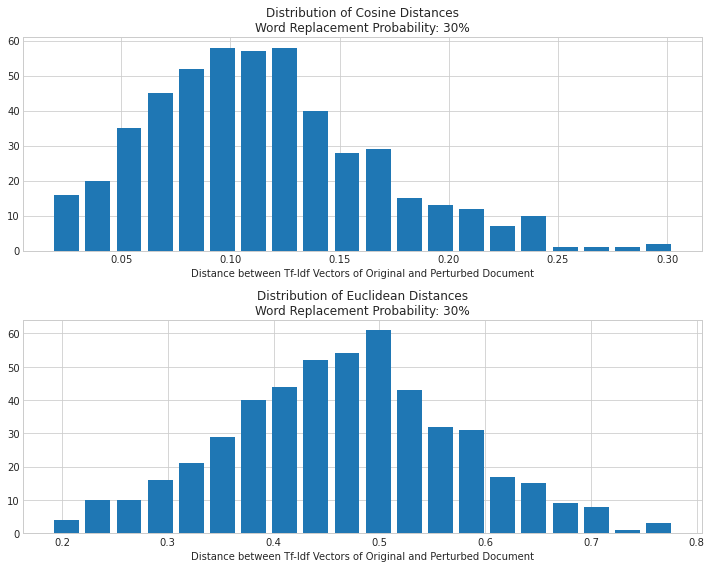

In [25]:
distances_c = np.empty((N_DOCS, SAMPLES_PER_DOC))
distances_e = np.empty((N_DOCS, SAMPLES_PER_DOC))

for i in tqdm_notebook(range(N_DOCS), "Document"):
    original_text = perturb_sample['text_norm'].iloc[i]
    for j in range(SAMPLES_PER_DOC):
        # default is 10% prob and 10 neighbors
        perturbed_text = ip.perturb_input_text_gensim(original_text, wv=wv, replace_p=0.3)
        c_ij = distance_between_text_pair(original_text, 
                                          perturbed_text, 
                                          vectorizer=lr_vectorizer,
                                          distance_fn='cosine')
        distances_c[i, j] = c_ij
        
        
        e_ij = distance_between_text_pair(original_text, 
                                          perturbed_text, 
                                          vectorizer=lr_vectorizer,
                                          distance_fn='euclidean')
        distances_e[i, j] = e_ij

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(10, 8))
ax[0].hist(distances_c.flatten(), rwidth=0.8, bins=20)
ax[0].set_title("Distribution of Cosine Distances\nWord Replacement Probability: 30%")
ax[0].set_xlabel("Distance between Tf-Idf Vectors of Original and Perturbed Document")

ax[1].hist(distances_e.flatten(), rwidth=0.8, bins=20)
ax[1].set_title("Distribution of Euclidean Distances\nWord Replacement Probability: 30%")
ax[1].set_xlabel("Distance between Tf-Idf Vectors of Original and Perturbed Document")

plt.tight_layout()
plt.show()

Interesting! It definitely scales up, and it takes longer because of the inner loop in the replacement function. The jump from 10% to 30% seemed to move the mode of the cosine distribution from ~0.02 to near 0.1. In the spirit of local Lipschitz working on small changes, I would tend to stick with the default I somewhat arbitrarily selected when writing the functions (10% token replacement using top 10 nearest neighbors)

One question arises from this: should we treat the sampling probability as the equivalent to the radius (and accept any/all variability that comes with it), or should we directly limit the distance measure of our choice (and discard perturbations that exceed $\epsilon$)? I'm thinking the latter, and I don't suppose it matters which distance metric we use, because it's just the denominator of the Lipschitz ratio we're trying to maximize. The behavior should be the same, but with a different scale. Since we calculated cosine and Euclidean distance on the same perturbations, we can prove this property empirically by plotting the two distance measures together.

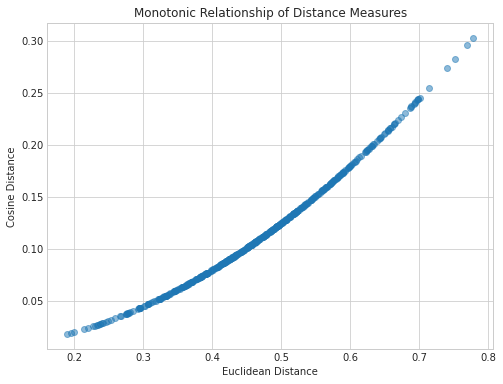

In [26]:
plt.figure(figsize=(8, 6))
plt.scatter(distances_e.flatten(), 
            distances_c.flatten(), alpha=0.5)
plt.title("Monotonic Relationship of Distance Measures")
plt.xlabel("Euclidean Distance")
plt.ylabel("Cosine Distance")
plt.show()

This means that we don't have to use Euclidean distance for the $||x_i - x_j||$ bit if we don't want to - since the two are monotinically related, it doesn't matter which we use as the denominator because we're just trying to maximize the ratio

Now we need to calculate the change in attribution between original and perturbed. This is going to be a little less function-friendly than the distance measures.

In [27]:
lr_shap = ShapKernel(lr.predict_proba, lr_vectorizer.transform(perturb_sample['text_norm']).toarray())

Write a function that returns an array of explanations for any of the `interpret` classes which have an `explain_local` method. It takes either a single string-valued document or an iterable of documents (passed directly to `vectorizer.transform`, and extracts the scores returned by the explainer for each vectorized document.

In [28]:
def interpret_explain_fn(text_norm, vectorizer, explainer):
    if type(text_norm) == str:
        text_norm = [text_norm]

    v = vectorizer.transform(text_norm).toarray()
    exp_out = explainer.explain_local(v)
    
    if not hasattr(explainer, 'lime'):
        return np.array([exp_out.data(i)['scores'] for i in range(len(text_norm))])
    else:
        # since LIME uses sparse local surrogate models, it returns an inconsistently indexed
        # array of scores - we need to align it with the full vectorizer size in order to compare
        num_docs = len(text_norm)
        num_features = len(explainer.feature_names)
        all_full_attributions = np.zeros((num_docs, num_features))
        for i in range(len(text_norm)):
            # get the features indices of the ones selected by LIME
            lime_attr_idx = np.array(list(
                map(lambda x: np.argmax(np.array(explainer.feature_names) == x),
                    exp_out.data(i)['names'])
            ))

            # overwrite the zeros in the matrix above with the true values
            all_full_attributions[i, lime_attr_idx] = np.array(exp_out.data(i)['scores'])
        return all_full_attributions

So here's an example of the process - we calculate the explanations for the original and perturbed text, take the Euclidean distance between the two (L2 norm of the elementwise difference), and then divide by our distance measure 

In [29]:
%%time
original_exp = interpret_explain_fn(original_text, lr_vectorizer, lr_shap)
perturb_exp = interpret_explain_fn(perturbed_text, lr_vectorizer, lr_shap)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 35.3 s, sys: 5.28 s, total: 40.6 s
Wall time: 12.2 s


L2 norm of the difference

In [30]:
np.linalg.norm(original_exp - perturb_exp)

0.09921778643499803

Divided by the distance measure (default is cosine)

In [31]:
np.linalg.norm(original_exp - perturb_exp) / distance_between_text_pair(original_text, perturbed_text, lr_vectorizer)

0.7722793988098499

And that's it! We would sample from this and retain the perturbation which maximizes the ratio above. For a similar figure to the one in the paper, we will actually care more about the distribution of maximum Lipschitz values from the perturbations. We'll want to limit the number of perturbations to save some compute time, but this should be the  approach for all models, and we can also compare explanations on the same perturbed documents!

## Develop the Transformer Calculation

Develop transformer method

In [32]:
from captum.attr import Saliency, IntegratedGradients

In [33]:
def embed_text(text, tokenizer=bb_tokenizer, model=bigbird):
    inputs = tokenizer(text, return_tensors='pt')
    embeds = model.bert.embeddings(inputs['input_ids'])
    return embeds

def classifier_forward_embeds(inputs, class_idx=1):
    logits = bigbird(inputs_embeds=inputs)['logits']
    return logits[:, class_idx]

In [34]:
distance_matrix = ip.construct_embedding_distance_matrix(bigbird.bert.embeddings.word_embeddings)

In [35]:
sal = Saliency(classifier_forward_embeds)

In [36]:
def decode_and_normalize(ids, tokenizer=bb_tokenizer, norm_fn=text_norm):
    raw_string = tokenizer.decode(ids.squeeze(), skip_special_tokens=False)
    norm_string = re.sub("⁇", "\n", raw_string)
    norm_string = re.sub("(^\[CLS\] )|(\[SEP\]$)", "", norm_string)
    return norm_fn(norm_string)

Document:   0%|          | 0/50 [00:00<?, ?it/s]

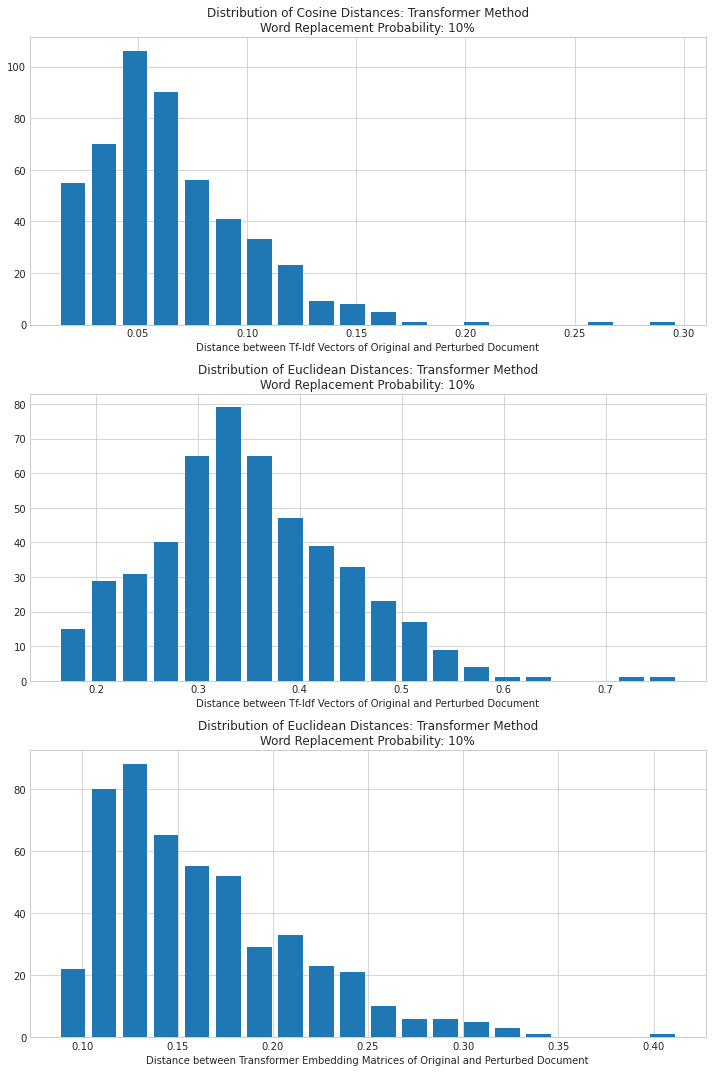

In [37]:
N_DOCS = perturb_sample.shape[0]
SAMPLES_PER_DOC = 10
distances_c = np.empty((N_DOCS, SAMPLES_PER_DOC))
distances_e = np.empty((N_DOCS, SAMPLES_PER_DOC))
distances_e_embeds = np.empty((N_DOCS, SAMPLES_PER_DOC))

for i in tqdm_notebook(range(N_DOCS), "Document"):
    original_tokens = bb_tokenizer(perturb_sample['text'].iloc[i], return_tensors='pt')['input_ids']
    original_embeds = bigbird.bert.embeddings(original_tokens)
    for j in range(SAMPLES_PER_DOC):
        # default is 10% prob and 10 neighbors
        perturbed_tokens = ip.perturb_input_ids_torch(original_tokens, distance_matrix)
        
        tfidf_vectors = lr_vectorizer.transform([
            decode_and_normalize(original_tokens),
            decode_and_normalize(perturbed_tokens),
        ])
        
        c_ij = cosine_distances(tfidf_vectors)[0, 1]
        distances_c[i, j] = c_ij
        
        e_ij = euclidean_distances(tfidf_vectors)[0, 1]
        distances_e[i, j] = e_ij
        
        perturbed_embeds = bigbird.bert.embeddings(perturbed_tokens)
        embed_distance = torch.norm(original_embeds - perturbed_embeds).item()
        # normalize by sequence length
        ee_ij = embed_distance / original_embeds.squeeze().size(0)
        distances_e_embeds[i, j] = ee_ij

fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(10, 15))
ax[0].hist(distances_c.flatten(), rwidth=0.8, bins=20)
ax[0].set_title("Distribution of Cosine Distances: Transformer Method\nWord Replacement Probability: 10%")
ax[0].set_xlabel("Distance between Tf-Idf Vectors of Original and Perturbed Document")

ax[1].hist(distances_e.flatten(), rwidth=0.8, bins=20)
ax[1].set_title("Distribution of Euclidean Distances: Transformer Method\nWord Replacement Probability: 10%")
ax[1].set_xlabel("Distance between Tf-Idf Vectors of Original and Perturbed Document")

ax[2].hist(distances_e_embeds.flatten(), rwidth=0.8, bins=20)
ax[2].set_title("Distribution of Euclidean Distances: Transformer Method\nWord Replacement Probability: 10%")
ax[2].set_xlabel("Distance between Transformer Embedding Matrices of Original and Perturbed Document")

plt.tight_layout()
plt.show()

This appears to be somewhere between the 10% and 30% gensim method we tried earlier. This is good enough - now, let's finish out the Lipschitz ratio for these

In [38]:
original_embeds = bigbird.bert.embeddings(original_tokens)
perturbed_embeds = bigbird.bert.embeddings(perturbed_tokens)

In [39]:
original_saliency = sal.attribute(original_embeds)
perturbed_saliency = sal.attribute(perturbed_embeds)

In [40]:
torch.norm(original_saliency - perturbed_saliency).item() / c_ij

12.75530545621708

In [41]:
ig = IntegratedGradients(classifier_forward_embeds)

In [42]:
%%time
original_ig = ig.attribute(original_embeds)
perturbed_ig = ig.attribute(perturbed_embeds)

CPU times: user 7min 13s, sys: 2min 9s, total: 9min 23s
Wall time: 35.2 s


Denominator: the Euclidean distance between the embedding matrices, normalized by the sequence length.

In [43]:
embed_distance = torch.norm(original_embeds - perturbed_embeds).item() / original_embeds.squeeze().size(0)
embed_distance

0.21453593059876044

Here, we'll put the Lipschitz calculation together for DL-based explanations. The $||f(x_i) - f(x_j)||_2$ piece is just the L2 distance between the 2-dimensional explanations for original and perturbed (attributed to the embedded input for each)

In [44]:
torch.norm(original_ig - perturbed_ig).item() / embed_distance

2.4851033780264506

In [45]:
torch.norm(original_saliency - perturbed_saliency).item() / embed_distance

3.573463474711464

## Put it all together
We now need to loop over documents and create a neighborhood for each observation. The original implementation used `skopt` for solving the maximization problem, but we will do a random search instead (since that library depends on numerical input). 

Based on the need to use Euclidean distance for Transformers, I'll do the same for the BOW-based models

In [46]:
lipschitz_sample = mp_valid.sample(35, random_state=9156191)

In [47]:
lr_lime = LimeTabular(lr.predict_proba, lr_vectorizer.transform(lipschitz_sample['text_norm']).toarray(), n_jobs=8)
lr_shap = ShapKernel(lr.predict_proba, lr_vectorizer.transform(lipschitz_sample['text_norm']).toarray(), n_jobs=8)

ebm_lime = LimeTabular(ebm.predict_proba, ebm_vectorizer.transform(lipschitz_sample['text_norm']).toarray(), n_jobs=8)
ebm_shap = ShapKernel(ebm.predict_proba, ebm_vectorizer.transform(lipschitz_sample['text_norm']).toarray(), n_jobs=8)

rf_shap = ShapKernel(rf.predict_proba, rf_vectorizer.transform(lipschitz_sample['text_norm']).toarray(), n_jobs=8)

ig = IntegratedGradients(classifier_forward_embeds, multiply_by_inputs=False)
saliency = Saliency(classifier_forward_embeds)

In [48]:
def local_lipschitz(original_exp, perturbed_exp, input_distance):
    # original_exp (# features) - perturbed_exps (# neighbors, # features) will broadcast across neighbors
    # --- note: this assumes that the perturbed_exp array represents as many documents as input_distances (for the division by distance)
    # taking L2 norm over axis=-1 will return the L2 norm for each perturbed neighbor
    # divide by euclidean distances for each neighbor to get a vector of (# neighbors)
    return np.linalg.norm(original_exp - perturbed_exp, axis=-1) / np.array(input_distance)

def local_lipschitz_torch(original_exp, perturbed_exp, distance):
    # this function is set up to do individual (non-batched) calculations for pytorch tensors
    return torch.norm(original_exp - perturbed_exp).item() / distance

In [49]:
N_DOCS = lipschitz_sample.shape[0]
MIN_NEIGHBORS_PER_DOC = 15
NUM_IG_STEPS = 20
EPSILON = 0.25

In [ ]:
max_lipschitz_values = {
    'LR LIME':[],
    'LR SHAP':[],
    'LR Truth':[],
    'EBM LIME':[],
    'EBM SHAP':[],
    'EBM Truth':[],
    'RF SHAP':[],
    'BigBird IG':[],
    'BigBird Saliency':[]
}

for i in tqdm_notebook(range(N_DOCS), "Document"):
    # take a document from the queue
    original_text_raw = lipschitz_sample['text'].iloc[i]
    original_text_norm = lipschitz_sample['text_norm'].iloc[i]
    
    # transformer input
    original_token_ids = bb_tokenizer(original_text_raw, return_tensors='pt')['input_ids']
    original_embeds = bigbird.bert.embeddings(original_token_ids)
    
    # --- local explanations for the original text: interpret library tooling
    original_shap_lr = interpret_explain_fn(original_text_norm, lr_vectorizer, lr_shap)
    original_lime_lr = interpret_explain_fn(original_text_norm, lr_vectorizer, lr_lime)
    original_truth_lr = interpret_explain_fn(original_text_norm, lr_vectorizer, lr)
    
    original_shap_ebm = interpret_explain_fn(original_text_norm, ebm_vectorizer, ebm_shap)
    original_lime_ebm = interpret_explain_fn(original_text_norm, ebm_vectorizer, ebm_lime)
    original_truth_ebm = interpret_explain_fn(original_text_norm, ebm_vectorizer, ebm)
    
    original_shap_rf = interpret_explain_fn(original_text_norm, rf_vectorizer, rf_shap)
    
    # --- local explanations for original text: bigbird
    original_ig = ig.attribute(original_embeds, n_steps=NUM_IG_STEPS)
    original_saliency = saliency.attribute(original_embeds)
    
    bow_neighborhood = {
        'distances':[],
        'perturbed_texts':[]
    }
    
    transformer_neighborhood = {
        'ig_lipschitz': [],
        'saliency_lipschitz':[]
    }
    
    # find members of the neighborhood 
    successful_bow_neighbors = 0
    while successful_bow_neighbors < MIN_NEIGHBORS_PER_DOC:
        perturbed_text = ip.perturb_input_text_gensim(original_text_norm, wv=wv)
        d_ij = distance_between_text_pair(original_text_norm, 
                                          perturbed_text, 
                                          vectorizer=lr_vectorizer,
                                          distance_fn='euclidean')
        
        # only add to the neighborhood if the cosine distance is below our defined radius
        if 0 <= d_ij <= EPSILON:
            successful_bow_neighbors += 1
            bow_neighborhood['perturbed_texts'] += [perturbed_text]
            bow_neighborhood['distances'] += [d_ij]
            
    # do the same for transformers, and calculate the attributions in the loop
    successful_transformer_neighbors = 0
    while successful_transformer_neighbors < MIN_NEIGHBORS_PER_DOC:
        perturbed_token_ids = ip.perturb_input_ids_torch(original_token_ids, distance_matrix, )
        perturbed_embeds = bigbird.bert.embeddings(perturbed_token_ids)
        
        # euclidean distance between embedding inputs, normalized by sequence length
        d_ij = torch.norm(original_embeds - perturbed_embeds).item() / original_embeds.squeeze().size(0)
        if 0 <= d_ij <= EPSILON:
            successful_transformer_neighbors += 1
            perturbed_ig = ig.attribute(perturbed_embeds, n_steps=NUM_IG_STEPS)
            transformer_neighborhood['ig_lipschitz'] += [local_lipschitz_torch(original_ig, perturbed_ig, d_ij)]
            perturbed_saliency = saliency.attribute(perturbed_embeds)
            transformer_neighborhood['saliency_lipschitz'] += [local_lipschitz_torch(original_saliency, perturbed_saliency, d_ij)]
            
    # calculate BOW explanations in a batch
    # returns a (# neighbors, # features) array
    perturbed_shap_lr = interpret_explain_fn(bow_neighborhood['perturbed_texts'], lr_vectorizer, lr_shap)
    perturbed_lime_lr = interpret_explain_fn(bow_neighborhood['perturbed_texts'], lr_vectorizer, lr_lime)
    perturbed_truth_lr = interpret_explain_fn(bow_neighborhood['perturbed_texts'], lr_vectorizer, lr)
    
    perturbed_shap_ebm = interpret_explain_fn(bow_neighborhood['perturbed_texts'], ebm_vectorizer, ebm_shap)
    perturbed_lime_ebm = interpret_explain_fn(bow_neighborhood['perturbed_texts'], ebm_vectorizer, ebm_lime)
    perturbed_truth_ebm = interpret_explain_fn(bow_neighborhood['perturbed_texts'], ebm_vectorizer, ebm)
    
    perturbed_shap_rf = interpret_explain_fn(bow_neighborhood['perturbed_texts'], rf_vectorizer, rf_shap)
    
    
    # calculate lipschitz constants for each of these documents
    # the local_lipschitz method is vectorized - it will broadcast across the vector-matrix subtraction, and then 
    # handle the elementwise division
    shap_lr_lipschitz_values = local_lipschitz(original_shap_lr, perturbed_shap_lr, bow_neighborhood['distances'])
    lime_lr_lipschitz_values = local_lipschitz(original_lime_lr, perturbed_lime_lr, bow_neighborhood['distances'])
    true_lr_lipschitz_values = local_lipschitz(original_truth_lr, perturbed_truth_lr, bow_neighborhood['distances'])
    
    shap_ebm_lipschitz_values = local_lipschitz(original_shap_ebm, perturbed_shap_ebm, bow_neighborhood['distances'])
    lime_ebm_lipschitz_values = local_lipschitz(original_lime_ebm, perturbed_lime_ebm, bow_neighborhood['distances'])
    true_ebm_lipschitz_values = local_lipschitz(original_truth_ebm, perturbed_truth_ebm, bow_neighborhood['distances'])
    
    shap_rf_lipschitz_values = local_lipschitz(original_shap_rf, perturbed_shap_rf, bow_neighborhood['distances'])
    
    # append the max lipschitz value for this document
    max_lipschitz_values['LR SHAP'] += [shap_lr_lipschitz_values.max()]
    max_lipschitz_values['LR LIME'] += [lime_lr_lipschitz_values.max()]
    max_lipschitz_values['LR Truth'] += [true_lr_lipschitz_values.max()]
    
    max_lipschitz_values['EBM SHAP'] += [shap_ebm_lipschitz_values.max()]
    max_lipschitz_values['EBM LIME'] += [lime_ebm_lipschitz_values.max()]
    max_lipschitz_values['EBM Truth'] += [true_ebm_lipschitz_values.max()]
    
    max_lipschitz_values['RF SHAP'] += [shap_rf_lipschitz_values.max()]
    
    max_lipschitz_values['BigBird IG'] += [max(transformer_neighborhood['ig_lipschitz'])]
    max_lipschitz_values['BigBird Saliency'] += [max(transformer_neighborhood['saliency_lipschitz'])]

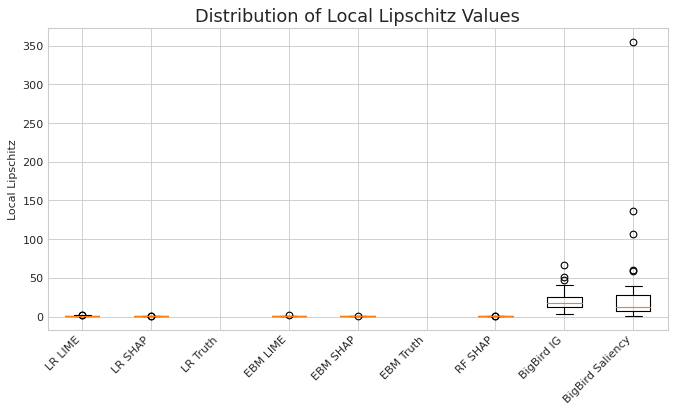

In [51]:
plt.figure(figsize=(10, 5), dpi=80)
plt.boxplot(max_lipschitz_values.values(), labels=max_lipschitz_values.keys())
plt.title("Distribution of Local Lipschitz Values", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Local Lipschitz")
plt.show()

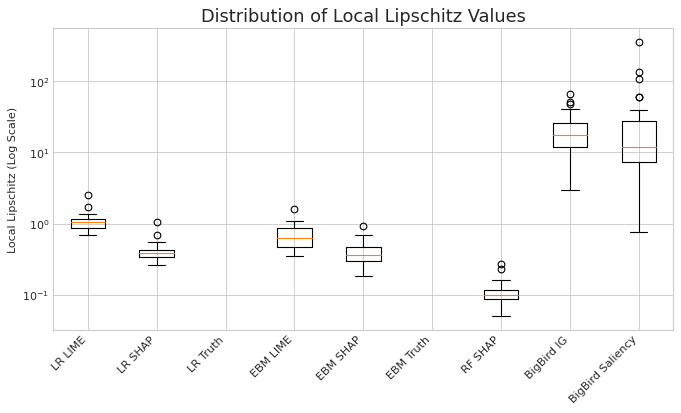

In [52]:
plt.figure(figsize=(10, 5), dpi=80)
plt.boxplot(max_lipschitz_values.values(), labels=max_lipschitz_values.keys())
plt.title("Distribution of Local Lipschitz Values", fontsize=16)
plt.yscale('log')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Local Lipschitz (Log Scale)")
plt.show()

Save these results into a file

In [53]:
pickle.dump(max_lipschitz_values, open('lipschitz_values.pkl', 'wb'))

## Infidelity
We can calculate explanation infidelity for a black-box prediction function with Captum - we just need to transform the input and output to PyTorch tensors. 

In [54]:
from captum.metrics import infidelity

In [55]:
def sklearn_preprocess_captum(text_norm, vectorizer):
    v = vectorizer.transform([text_norm]).toarray()
    return torch.from_numpy(v)

def sklearn_forward_captum(x:torch.Tensor, model=lr):
    x_np = x.numpy()
    return torch.Tensor(model.predict_proba(x_np)[:, 1])

We also need a perturbation function, which in our case will be subtracting Gaussian noise.

In [56]:
def perturb_tensor(embeds, std=0.005):
    noise = torch.empty_like(embeds).normal_(mean=0, std=std)
    return noise, embeds - noise

Transformer example

In [57]:
infidelity(forward_func=classifier_forward_embeds, 
           perturb_func=perturb_tensor, 
           inputs=original_embeds,
           attributions=original_ig)

tensor([8.4253e-05], dtype=torch.float64)

Traditional example

In [58]:
original_exp = interpret_explain_fn(original_text, lr_vectorizer, lr_shap)

  0%|          | 0/1 [00:00<?, ?it/s]

In [59]:
infidelity(forward_func=lambda x: sklearn_forward_captum(x, model=lr), 
           perturb_func=perturb_tensor, 
           inputs=sklearn_preprocess_captum(original_text, lr_vectorizer),
           attributions=torch.from_numpy(original_exp))

tensor([0.0042], dtype=torch.float64)

As we can see, there is a huge difference in the infidelity results between these two examples. This could be due to the differences between LIME and integrated gradients, or it could be due to differences in the scale of these inputs. Let's examine this - I'm going to perturb the inputs using the default width (standard deviation of 5e-3) and take the L2 distance resulting from the perturbation (the first returned value from `perturb_tensor`)

In [60]:
lr_delta = perturb_tensor(sklearn_preprocess_captum(original_text, lr_vectorizer))[0]
torch.norm(lr_delta)

tensor(0.1610, dtype=torch.float64)

For the transformer, we'll normalize by sequence length

In [61]:
embed_delta = perturb_tensor(original_embeds)[0]
torch.norm(embed_delta) / original_embeds.squeeze().size(0)

tensor(0.0051)

There definitely is a difference in the results - what's the difference in the variability of the inputs?

In [62]:
print("--- Traditional input ---")
print("Global Std. Dev", valid_tfidf.toarray().std())
print("Average Std. Dev of each feature", valid_tfidf.toarray().std(0).mean())

--- Traditional input ---
Global Std. Dev 0.030604185106438506
Average Std. Dev of each feature 0.023106444742881992


For transformer, what's the variability within the embedding matrix?

In [63]:
print("--- Embedding input ---")
print("Global Std. Dev", bigbird.bert.embeddings.word_embeddings.weight.data.std().item())
print("Average Std. Dev of each feature", bigbird.bert.embeddings.word_embeddings.weight.data.std(0).mean().item())

--- Embedding input ---
Global Std. Dev 0.06553805619478226
Average Std. Dev of each feature 0.0607687272131443


Interesting! There is a higher standard deviation in the embedding matrix, which makes sense that it would be less affected by the same level of noise than the TF-IDF.

However, this doesn't necessarily reflect the variation in the tokens we actually use.

In [64]:
original_embeds.squeeze().std(0).mean()

tensor(0.4184, grad_fn=<MeanBackward0>)

In [65]:
sklearn_preprocess_captum(original_text, lr_vectorizer).std()

tensor(0.0310, dtype=torch.float64)

As we can see, there is much wider variation in the embeddings for a representative document. We can address this by taking the standard deviation of the embedding matrix for several documents to get a better sample. 

We'll also scale the amount of variation for both methods to control the results and avoid absurd inputs.

In [66]:
SCALAR = 5

In [67]:
traditional_sigma = valid_tfidf.toarray().std()
traditional_sigma /= SCALAR

lr_delta = perturb_tensor(sklearn_preprocess_captum(original_text, lr_vectorizer), 
                          std=traditional_sigma)[0]
torch.norm(lr_delta)

tensor(0.1931, dtype=torch.float64)

Calculate something similar for the transformer model, using the word embeddings for a random sample of documents.

In [68]:
sigmas = []
for text in mp_valid['text'].sample(500, random_state=6548):
    embeds = embed_text(text)
    sigmas += [embeds.std().item()]
    
xf_sigma = np.mean(sigmas) / SCALAR

In [69]:
embed_delta, perturbed = perturb_tensor(original_embeds, std=xf_sigma)
torch.norm(embed_delta) / original_embeds.squeeze().size(0)

tensor(0.0880)

In [70]:
perturbed.norm().item(), original_embeds.norm().item()

(328.1531982421875, 321.7825622558594)

In [71]:
traditional_sigma, xf_sigma

(0.006120837021287701, 0.08581820799112319)

Now for a loop over the same documents as Lipschitz to calculate a distribution of infidelity.

In [72]:
def infidelity_traditional(vector_input, model, explanations, std=traditional_sigma):
    inf_value = infidelity(forward_func=lambda x: sklearn_forward_captum(x, model), 
                           perturb_func=lambda x: perturb_tensor(x, std=std), 
                           inputs=vector_input,
                           attributions=torch.from_numpy(explanations))
    return inf_value.item()

In [73]:
def infidelity_transformer(embed_input, explanations, std=xf_sigma):
    inf_value = infidelity(forward_func=classifier_forward_embeds, 
                           perturb_func=lambda x: perturb_tensor(x, std=std),
                           inputs=embed_input,
                           attributions=explanations)
    
    return inf_value.item()

In [74]:
infidelity_sample = mp_valid.sample(100, random_state=9784613)

In [ ]:
infidelities = {
    'LR LIME':[],
    'LR SHAP':[],
    'LR Truth':[],
    'EBM LIME':[],
    'EBM SHAP':[],
    'EBM Truth':[],
    'RF SHAP':[],
    'BigBird IG':[],
    'BigBird Saliency':[]
}

for i in tqdm_notebook(range(infidelity_sample.shape[0]), "Document"):
    # take a document from the queue
    original_text_raw = infidelity_sample['text'].iloc[i]
    original_text_norm = infidelity_sample['text_norm'].iloc[i]
    
    # transformer input
    original_token_ids = bb_tokenizer(original_text_raw, return_tensors='pt')['input_ids']
    original_embeds = bigbird.bert.embeddings(original_token_ids)
    
    # EBM input
    lr_input = sklearn_preprocess_captum(original_text_norm, lr_vectorizer)
    ebm_input = sklearn_preprocess_captum(original_text_norm, ebm_vectorizer)
    rf_input = sklearn_preprocess_captum(original_text_norm, rf_vectorizer)
    
    ## calculate infidelity values
    
    # LR
    original_shap_lr = interpret_explain_fn(original_text_norm, lr_vectorizer, lr_shap)
    infidelities['LR SHAP'] += [infidelity_traditional(lr_input, lr, original_shap_lr)]
    
    original_lime_lr = interpret_explain_fn(original_text_norm, lr_vectorizer, lr_lime)
    infidelities['LR LIME'] += [infidelity_traditional(lr_input, lr, original_lime_lr)]
    
    original_truth_lr = interpret_explain_fn(original_text_norm, lr_vectorizer, lr)
    infidelities['LR Truth'] += [infidelity_traditional(lr_input, lr, original_truth_lr)]
    
    # EBM
    original_shap_ebm = interpret_explain_fn(original_text_norm, ebm_vectorizer, ebm_shap)
    infidelities['EBM SHAP'] += [infidelity_traditional(ebm_input, ebm, original_shap_ebm)]
    
    original_lime_ebm = interpret_explain_fn(original_text_norm, ebm_vectorizer, ebm_lime)
    infidelities['EBM LIME'] += [infidelity_traditional(ebm_input, ebm, original_lime_ebm)]
    
    # EBM's true explanations are greater in length than inputs because of interactions
    # using only direct input attributions for this
    original_truth_ebm = interpret_explain_fn(original_text_norm, ebm_vectorizer, ebm)
    infidelities['EBM Truth'] += [infidelity_traditional(ebm_input, ebm, 
                                                         original_truth_ebm[:, :ebm_input.size(1)])]
    
    # random forest
    original_shap_rf = interpret_explain_fn(original_text_norm, rf_vectorizer, rf_shap)
    infidelities['RF SHAP'] += [infidelity_traditional(rf_input, rf, original_shap_rf)]
    
    ## Transformer
    # integrated gradients
    original_ig = ig.attribute(original_embeds, n_steps=NUM_IG_STEPS)
    infidelities['BigBird IG'] += [infidelity_transformer(original_embeds, original_ig)]
    
    # saliency
    original_saliency = saliency.attribute(original_embeds)
    infidelities['BigBird Saliency'] += [infidelity_transformer(original_embeds, original_saliency)]

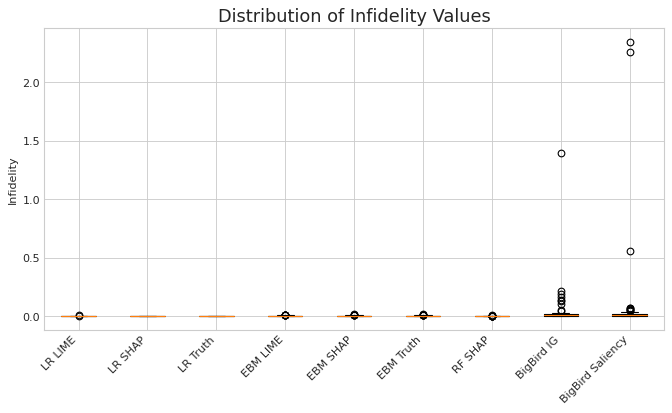

In [76]:
plt.figure(figsize=(10, 5), dpi=80)
plt.boxplot(infidelities.values(), labels=infidelities.keys())
plt.title("Distribution of Infidelity Values", fontsize=16)
plt.ylabel("Infidelity")
plt.xticks(rotation=45, ha='right')
plt.show()

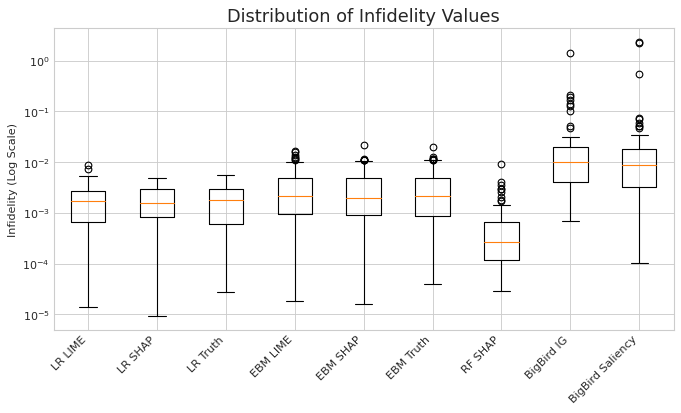

In [77]:
plt.figure(figsize=(10, 5), dpi=80)
plt.boxplot(infidelities.values(), labels=infidelities.keys())
plt.title("Distribution of Infidelity Values", fontsize=16)
plt.yscale('log')
plt.ylabel("Infidelity (Log Scale)")
plt.xticks(rotation=45, ha='right')
plt.show()

In [78]:
pickle.dump(infidelities, open('infidelity_values.pkl', 'wb'))